# Title

## Pre-requisites



## Setup

`docker run -p 7080:8080 deciphernow/fail`

In [1]:
import os
import multiprocessing as mp
import subprocess as sp
import time
from http import client
import yaml

import numpy as np

import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [2]:
def call(fail_rate=10):
    """Defines the work unit on an input file"""

    host = "localhost"
    port = "80"

    fail_rate = int(fail_rate)
    
    c = client.HTTPConnection(host, 10000, timeout=10)
    start = time.time()
    c.request("GET", "/maybe/fail?rate={}".format(fail_rate))
    elapsed = time.time() - start

    response = c.getresponse()
    resp_body = response.read().decode("utf-8")
    
    return response.code, elapsed

In [3]:
def run_envoy():
    """Thingy"""
    
    proc = sp.Popen(["./envoy", "-c", "config.yaml"])
    
    return proc

In [4]:
def set_num_retries(config, retries=1):
    """stuff"""
    retry_policy = {"retry_on": "5xx",
                    "num_retries": retries}
    
    data = yaml.load(open(config).read())
    
    if retries == 0:
        try: 
            del data["static_resources"]['listeners'][0]['filter_chains'][0]["filters"][0]['typed_config']['route_config']['virtual_hosts'][0]['routes'][0]['route']['retry_policy']
        except KeyError:
            pass
    else: 
        data["static_resources"]['listeners'][0]['filter_chains'][0]["filters"][0]['typed_config']['route_config']['virtual_hosts'][0]['routes'][0]['route']['retry_policy'] = retry_policy
        
    with open(config, 'w') as output:
        output.write(yaml.dump(data))

In [5]:
def run(retries, fail_rate=10, n_trials=10000):
    set_num_retries("./config.yaml", retries)
    proc = run_envoy()
    time.sleep(2)
    
    pool = mp.Pool(processes=1)

    data = pool.map(call, fail_rate * np.ones(n_trials))
    success = len([item for item in data if item[0] == 200])
    error = len([item for item in data if item[0] != 200])

    print("{}/{}, {}".format(error, success, 100*error/(success+error)))

    print("N 2xx: ", os.popen("curl localhost:9901/stats | grep cluster.service.upstream_rq_2xx").read().strip())
    print("N 5xx: ", os.popen("curl localhost:9901/stats | grep cluster.service.upstream_rq_5xx").read().strip())
    print("N Retry: ", os.popen("curl localhost:9901/stats | grep cluster.service.upstream_rq_retry:").read().strip())
    
    proc.kill()
    time.sleep(2)
    
    return data

In [6]:
%%time
# 0 Retries

data = run(0, n_trials=100000)

9979/90021, 9.979
N 2xx:  cluster.service.upstream_rq_2xx: 90021
N 5xx:  cluster.service.upstream_rq_5xx: 9979
N Retry:  cluster.service.upstream_rq_retry: 0
CPU times: user 280 ms, sys: 33.2 ms, total: 313 ms
Wall time: 1min 32s


In [7]:
%%time
# 1 Retry

data1 = run(1, n_trials=100000)

1038/98962, 1.038
N 2xx:  cluster.service.upstream_rq_2xx: 98962
N 5xx:  cluster.service.upstream_rq_5xx: 1038
N Retry:  cluster.service.upstream_rq_retry: 9996
CPU times: user 427 ms, sys: 123 ms, total: 551 ms
Wall time: 4min 12s


In [8]:
%%time
# 2 Retries

data2 = run(2, n_trials=100000)

92/99908, 0.092
N 2xx:  cluster.service.upstream_rq_2xx: 99908
N 5xx:  cluster.service.upstream_rq_5xx: 92
N Retry:  cluster.service.upstream_rq_retry: 11115
CPU times: user 588 ms, sys: 166 ms, total: 754 ms
Wall time: 4min 55s


In [9]:
%%time
# 3 Retries

data3 = run(3, n_trials=100000)

9/99991, 0.009
N 2xx:  cluster.service.upstream_rq_2xx: 99991
N 5xx:  cluster.service.upstream_rq_5xx: 9
N Retry:  cluster.service.upstream_rq_retry: 11015
CPU times: user 685 ms, sys: 237 ms, total: 922 ms
Wall time: 4min 58s


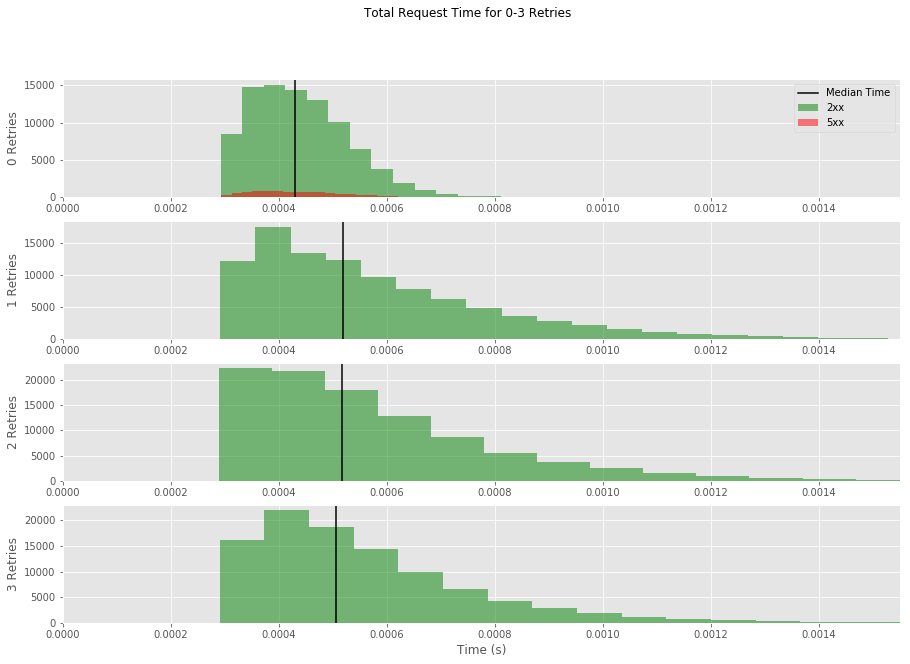

In [10]:
fig = plt.figure(figsize=(15, 10))
fig.suptitle("Total Request Time for 0-3 Retries")
x_min = 0
x_max = 3*np.median([item[1] for item in data2])

ax = fig.add_subplot(4, 1, 1)
_ = ax.hist([item[1] for item in data if item[0] == 200], bins=200, color='g', alpha=.5, label="2xx")
_ = ax.hist([item[1] for item in data if item[0] != 200], bins=200, color='r', alpha=.5, label="5xx")
_ = ax.axvline(np.median([item[1] for item in data]), color='k', label="Median Time")
_ = ax.set_xlim((x_min, x_max))
_ = ax.set_ylabel("0 Retries")
_ = ax.legend()
                
ax1 = fig.add_subplot(4, 1, 2)
_ = ax1.hist([item[1] for item in data1 if item[0] == 200], bins=200, color='g', alpha=.5)
_ = ax1.hist([item[1] for item in data1 if item[0] != 200], bins=200, color='r', alpha=.5)
_ = ax1.axvline(np.median([item[1] for item in data1]), color='k')
_ = ax1.set_ylabel("1 Retries")
_ = ax1.set_xlim((x_min, x_max))

ax2 = fig.add_subplot(4, 1, 3)
_ = ax2.hist([item[1] for item in data2 if item[0] == 200], bins=200, color='g', alpha=.5)
_ = ax2.hist([item[1] for item in data2 if item[0] != 200], bins=200, color='r', alpha=.5)
_ = ax2.axvline(np.median([item[1] for item in data2]), color='k')
_ = ax2.set_ylabel("2 Retries")
_ = ax2.set_xlim((x_min, x_max))

ax3 = fig.add_subplot(4, 1, 4)
_ = ax3.hist([item[1] for item in data3 if item[0] == 200], bins=200, color='g', alpha=.5)
_ = ax3.hist([item[1] for item in data3 if item[0] != 200], bins=200, color='r', alpha=.5)
_ = ax3.axvline(np.median([item[1] for item in data3]), color='k')
_ = ax3.set_xlim((x_min, x_max))
_ = ax3.set_xlabel("")
_ = ax3.set_ylabel("3 Retries")
_ = ax3.set_xlabel("Time (s)")


In [11]:
%%time 

n_retries = range(6)
fail_rate = range(1, 30, 1)

outputs = {}

for r in fail_rate:
    if not r in outputs:
        outputs[r] = {"x": [], "y": []}
    for n in n_retries:
        data = run(n, r, 20000)
        success = len([item for item in data if item[0] == 200])
        error = len([item for item in data if item[0] != 200])
        print(r, n, 100*error/(success+error))
        outputs[r]["x"].append(n)
        outputs[r]["y"].append(100*error/(success+error))


193/19807, 0.965
N 2xx:  cluster.service.upstream_rq_2xx: 19807
N 5xx:  cluster.service.upstream_rq_5xx: 193
N Retry:  cluster.service.upstream_rq_retry: 0
1 0 0.965
2/19998, 0.01
N 2xx:  cluster.service.upstream_rq_2xx: 19998
N 5xx:  cluster.service.upstream_rq_5xx: 2
N Retry:  cluster.service.upstream_rq_retry: 201
1 1 0.01
0/20000, 0.0
N 2xx:  cluster.service.upstream_rq_2xx: 20000
N 5xx:  
N Retry:  cluster.service.upstream_rq_retry: 205
1 2 0.0
0/20000, 0.0
N 2xx:  cluster.service.upstream_rq_2xx: 20000
N 5xx:  
N Retry:  cluster.service.upstream_rq_retry: 197
1 3 0.0
0/20000, 0.0
N 2xx:  cluster.service.upstream_rq_2xx: 20000
N 5xx:  
N Retry:  cluster.service.upstream_rq_retry: 211
1 4 0.0
0/20000, 0.0
N 2xx:  cluster.service.upstream_rq_2xx: 20000
N 5xx:  
N Retry:  cluster.service.upstream_rq_retry: 217
1 5 0.0
369/19631, 1.845
N 2xx:  cluster.service.upstream_rq_2xx: 19631
N 5xx:  cluster.service.upstream_rq_5xx: 369
N Retry:  cluster.service.upstream_rq_retry: 0
2 0 1.845
7/

10 2 0.09
1/19999, 0.005
N 2xx:  cluster.service.upstream_rq_2xx: 19999
N 5xx:  cluster.service.upstream_rq_5xx: 1
N Retry:  cluster.service.upstream_rq_retry: 2240
10 3 0.005
0/20000, 0.0
N 2xx:  cluster.service.upstream_rq_2xx: 20000
N 5xx:  
N Retry:  cluster.service.upstream_rq_retry: 2272
10 4 0.0
0/20000, 0.0
N 2xx:  cluster.service.upstream_rq_2xx: 20000
N 5xx:  
N Retry:  cluster.service.upstream_rq_retry: 2205
10 5 0.0
2180/17820, 10.9
N 2xx:  cluster.service.upstream_rq_2xx: 17820
N 5xx:  cluster.service.upstream_rq_5xx: 2180
N Retry:  cluster.service.upstream_rq_retry: 0
11 0 10.9
250/19750, 1.25
N 2xx:  cluster.service.upstream_rq_2xx: 19750
N 5xx:  cluster.service.upstream_rq_5xx: 250
N Retry:  cluster.service.upstream_rq_retry: 2156
11 1 1.25
24/19976, 0.12
N 2xx:  cluster.service.upstream_rq_2xx: 19976
N 5xx:  cluster.service.upstream_rq_5xx: 24
N Retry:  cluster.service.upstream_rq_retry: 2443
11 2 0.12
0/20000, 0.0
N 2xx:  cluster.service.upstream_rq_2xx: 20000
N 5xx: 

19 0 19.04
753/19247, 3.765
N 2xx:  cluster.service.upstream_rq_2xx: 19247
N 5xx:  cluster.service.upstream_rq_5xx: 753
N Retry:  cluster.service.upstream_rq_retry: 3786
19 1 3.765
141/19859, 0.705
N 2xx:  cluster.service.upstream_rq_2xx: 19859
N 5xx:  cluster.service.upstream_rq_5xx: 141
N Retry:  cluster.service.upstream_rq_retry: 4473
19 2 0.705
28/19972, 0.14
N 2xx:  cluster.service.upstream_rq_2xx: 19972
N 5xx:  cluster.service.upstream_rq_5xx: 28
N Retry:  cluster.service.upstream_rq_retry: 4806
19 3 0.14
2/19998, 0.01
N 2xx:  cluster.service.upstream_rq_2xx: 19998
N 5xx:  cluster.service.upstream_rq_5xx: 2
N Retry:  cluster.service.upstream_rq_retry: 4713
19 4 0.01
2/19998, 0.01
N 2xx:  cluster.service.upstream_rq_2xx: 19998
N 5xx:  cluster.service.upstream_rq_5xx: 2
N Retry:  cluster.service.upstream_rq_retry: 4940
19 5 0.01
4049/15951, 20.245
N 2xx:  cluster.service.upstream_rq_2xx: 15951
N 5xx:  cluster.service.upstream_rq_5xx: 4049
N Retry:  cluster.service.upstream_rq_retry

27 1 7.055
372/19628, 1.86
N 2xx:  cluster.service.upstream_rq_2xx: 19628
N 5xx:  cluster.service.upstream_rq_5xx: 372
N Retry:  cluster.service.upstream_rq_retry: 6822
27 2 1.86
105/19895, 0.525
N 2xx:  cluster.service.upstream_rq_2xx: 19895
N 5xx:  cluster.service.upstream_rq_5xx: 105
N Retry:  cluster.service.upstream_rq_retry: 7090
27 3 0.525
34/19966, 0.17
N 2xx:  cluster.service.upstream_rq_2xx: 19966
N 5xx:  cluster.service.upstream_rq_5xx: 34
N Retry:  cluster.service.upstream_rq_retry: 7319
27 4 0.17
9/19991, 0.045
N 2xx:  cluster.service.upstream_rq_2xx: 19991
N 5xx:  cluster.service.upstream_rq_5xx: 9
N Retry:  cluster.service.upstream_rq_retry: 7323
27 5 0.045
5614/14386, 28.07
N 2xx:  cluster.service.upstream_rq_2xx: 14386
N 5xx:  cluster.service.upstream_rq_5xx: 5614
N Retry:  cluster.service.upstream_rq_retry: 0
28 0 28.07
1535/18465, 7.675
N 2xx:  cluster.service.upstream_rq_2xx: 18465
N 5xx:  cluster.service.upstream_rq_5xx: 1535
N Retry:  cluster.service.upstream_rq_r

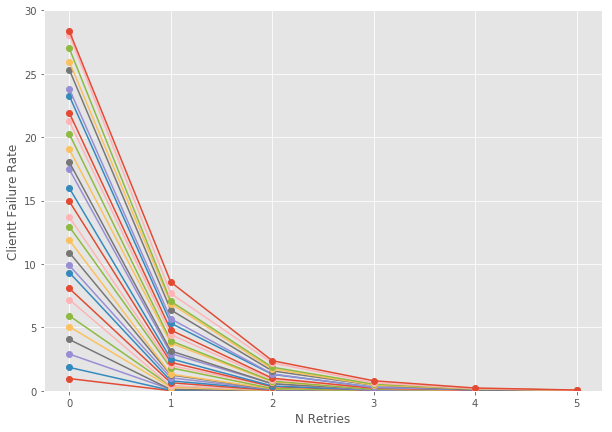

In [12]:
norm = plt.Normalize()
colors = plt.cm.jet(norm(4*list(fail_rate)))

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(1, 1, 1)
_ = ax.set_title("")
_ = ax.set_ylabel("Clientt Failure Rate")
_ = ax.set_xlabel("N Retries")
#_ = ax.set_yscale("log")
_ = ax.set_ylim((0, 30))
for item in outputs:
    plt.plot(outputs[item]['x'], outputs[item]['y'], 'o-', label=item)